Reference)

https://github.com/ageitgey/face_recognition

https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/

In [12]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import os

import face_recognition # by Adam Geitgey, a PyImageConf2018 speaker
import cv2

from PIL import Image

# Encoding faces via deep learning

In [3]:
# input 이미지들의 path 따오는 코드. 이미지의 절대 경로를 반환.
def load_directory_data(pwd):

    file_path_list = []
    
    # 디렉토리, 디렉토리 내 폴더 리스트, 파일 리스트
    for path,dirs,files in os.walk(pwd):
        
        for f in files:           
            file_path = path + '/' +f
            file_path_list.append(file_path)             
    
    print("# of files: ",len(file_path_list))
    
    return file_path_list

print("[INFO] quantifying faces...")
imagePaths = load_directory_data('Sample Data Collection From MELD/SampleFaces')

[INFO] quantifying faces...
# of files:  79


In [4]:
# loop over the image paths
data = []

for (i, imagePath) in enumerate(imagePaths):
    
    # load the input image and convert it from BGR (OpenCV ordering) to dlib ordering (RGB) 
    print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)), end = '\r') # 작업량 카운트
    image = cv2.imread(imagePath)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV’s default BGR to RGB, dlib가 rgb만 받음.
   
    # 본 코드에서는 기본 이미지 크기를 임의로 box 를 만들었는데, input 이미지가 이미 얼굴만 잘린 이미지이기 때문.
    boxes = [(0,image.shape[0],image.shape[1],0)] # 인물의 얼굴을 좌표로 반환. (top, right, bottom, left)

    # Given an image, return the 128-dimension face encoding for each face in the image.
    encodings = face_recognition.face_encodings(rgb_img, boxes)

    # build a dictionary of the image path, bounding box location, and facial encodings for the current image
    d = {"imagePath": imagePath, "loc": boxes, "encoding": encodings}
    data.append(d)

print(len(data))

79NFO] processing image 79/79


Boxes가 없는 경우 encoding 오류 날 때 있다. 원래 Face 얼굴대로 Crop된 이미지들 이므로 box의 크기를 이미지 사이즈 그대로 설정하였다.

In [5]:
import pickle

# save
with open('face_encoding.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

For each of the detected faces + encodings, we build a dictionary that includes:

1. The path to the input image
2. The location of the face in the image (i.e., the bounding box)
3. The 128-d encoding itself

# Face Clustering 

In [6]:
# import the necessary packages
from sklearn.cluster import DBSCAN

In [7]:
# load encoding data
with open('face_encoding.pickle', 'rb') as f:
    data = pickle.load(f)

encodings = [d["encoding"] for d in data]
print(np.array(encodings).shape)

(79, 1, 128)


이 상태로 DBSCAN 에 넣는다면 shape error가 발생한다.

In [8]:
# flatten encoding array (79,1,128) --> (79,128)

encoding_new = []

for e in encodings:
    encoding_new.append(np.array(e).flatten())
    
print(np.array(encoding_new).shape)

(79, 128)


In [70]:
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(metric = "euclidean", n_jobs = 4)
clt.fit(encoding_new)
print(clt.labels_)

# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
#print(labelIDs)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] clustering...
[ 0  3  0  1  0  1  0  1  1  2  2  1 -1  2  0  3  1  1  4  0  3  1  1  3
  4  0  2  4  4  1  1  2  2  3  1 -1  1  0  1  2  4  1  4  1  1  1  1  4
  3  4  0  0 -1  4  1  0  2  4  1  4  0 -1  3  3  1  1  2  3  2 -1 -1  3
  0  4 -1  2  4  1  2]
[INFO] # unique faces: 5


In [67]:
import collections
print("군집 별 개수:",collections.Counter(clt.labels_))

군집 별 개수: Counter({1: 24, 0: 13, 4: 13, 2: 12, 3: 10, -1: 7})


# Result

In [77]:
pd.DataFrame(labelIDs)
label_dict= {}
for i in labelIDs:
    label_dict[i] = data[0]['imagePath']
    label_dict[i] = data[1]['imagePath']
    
label_dict

{-1: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg',
 0: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg',
 1: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg',
 2: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg',
 3: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg',
 4: 'Sample Data Collection From MELD/SampleFaces/dia8_utt0_3.2_speaker0_test.jpg'}

In [78]:
label_out = []
label_0 = []
label_1 = []
label_2 = []
label_3 = []
label_4 = []


for i,d in enumerate(data):
    if clt.labels_[i] == -1 :
        label_out.append(data[i]['imagePath'])
    elif clt.labels_[i] == 0 :
        label_0.append(data[i]['imagePath'])
    elif clt.labels_[i] == 1 :
        label_1.append(data[i]['imagePath'])
    elif clt.labels_[i] == 2 :
        label_2.append(data[i]['imagePath'])
    elif clt.labels_[i] == 3 :
        label_3.append(data[i]['imagePath'])
    elif clt.labels_[i] == 4 :
        label_4.append(data[i]['imagePath'])       

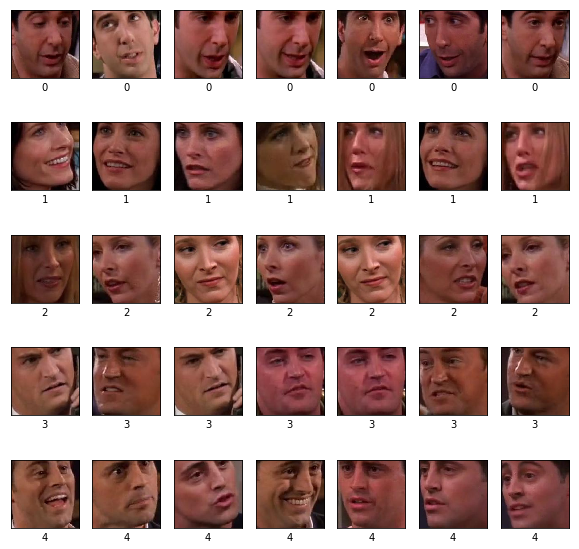

In [79]:
# Result of Clustering without outlier
label_total = label_0[:7] + label_1[:7] + label_2[:7] + label_3[:7] + label_4[:7]

plt.figure(figsize=(10,10))
for i,img_dir in enumerate(label_total):
    
    img = cv2.imread(img_dir)
    plt.subplot(5,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(int(i/7)))
    plt.grid(False)
    
    # show color image
    img_color = img.copy()
    img_color[:, :, 0] = img[:, :, 2]
    img_color[:, :, 2] = img[:, :, 0]
    plt.imshow(img_color)
    
plt.show()

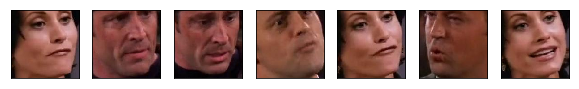

In [80]:
# Result of Clustering outlier
# Result of Clustering without outlier

plt.figure(figsize=(10,10))
for i,img_dir in enumerate(label_out):
    
    img = cv2.imread(img_dir)
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # show color image
    img_color = img.copy()
    img_color[:, :, 0] = img[:, :, 2]
    img_color[:, :, 2] = img[:, :, 0]
    plt.imshow(img_color)
    
plt.show()